In [1]:
%pylab inline

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

from keras import backend as K

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


Recall the general architecture of the VGG model ([Notes here](https://napsterinblue.github.io/notes/machine_learning/computer_vision/vgg/)).

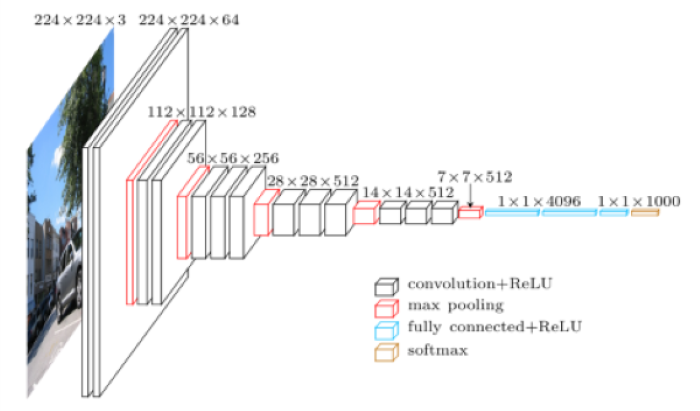

In [2]:
from IPython.display import Image

Image('images/vgg_long.png')

If we load up the `keras` implementation of the weights (ignoring the top layers, as we're not actually going to be predicting anything)

In [3]:
from keras.applications import VGG16

model = VGG16(weights='imagenet',
              include_top=False)

... we can see that it's very large.

In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

This tutorial is meant to shed some light on the types of intermediate features that these hidden layers are looking at.

## Methodology Overview

Broadly, we know that training a Neural Network involves:

1. Setting the model structure
2. Defining the loss
3. Minimizing that loss

Which means that, crucially, the connections from layer to layer are differentiable and aggregate to some comprehensive loss function.

A good intermediate filter can:

1. "Spot a particular pattern in our image" 
2. Pass some information to the next layer that confirms "yeah, I saw this pattern"

Over multiple training steps, this *information passed to the next layer* is adjusted by performing gradient descent to arrive at a series of weights that minimize this filter's contribution to the loss of the whole model.

The key mechanic we're going to be using here basically up-ends this whole idea. Instead of using the gradient to go from image to "singular information value" to minimize loss, we're going to *multiply by this gradient* to make adjustments to the image to *maximize loss*.

With enough repetition, this will give us an image with higher and higher loss for this filter, which translates in English to "an image tailor made to activate this particular filter."

### Visualizing One Filter of One Layer

So to get a ground-level intuition for how this all works, we're going to zero in on *one* filter of *one* block.

Arbitrarily-chosen, we've got:

In [5]:
layer_name = 'block3_conv1'
filter_index = 27

And so we grab the layer that we're interested in examining

In [6]:
layer_output = model.get_layer(layer_name).output

It's got `256` different filters

In [7]:
layer_output.shape

TensorShape([Dimension(None), Dimension(None), Dimension(None), Dimension(256)])

So we'll just look at the filter we're interested in. We create an object called `loss`, which will be the outbound calculation for the loss that the network is trained to minimize.

In [8]:
loss = K.mean(layer_output[:, :, :, filter_index])

**Note**: This isn't the value of the loss-- a cut-and-dry number-- but instead, the *variable that will hold the value of the loss* as the network adjusts. We take the `mean` value to make the optimization more straight-forward.

In [9]:
type(loss)

tensorflow.python.framework.ops.Tensor

In [10]:
loss.shape

TensorShape([])

Similarly, we define an object, `grads`, that will hold the value of the loss gradient, used in our repeated ascent step.

Looking closer, `K.gradients` evaluates our `loss` function (defined above), at the point defined by the `model.input`-- in this case, an image of a consistent size. Per usual, we normalize that value, and the resulting `grads` object provides a gradient value across `(R, G, B)`

In [11]:
grads = K.gradients(loss=loss, variables=model.input)[0]
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

grads.shape

TensorShape([Dimension(None), Dimension(None), Dimension(None), Dimension(3)])

Next, in the spirit of "define the steps/placeholders", we'll use the `K.function` to define our iteration step.

Essentially, this lambda function will look for an image of our consistent size, and return `loss` and `grads` used to update our image at each step.

We'll take one step over an image of all black to initialize the values of `loss_value` and `grads_value`.

In [12]:
iterate = K.function(inputs=[model.input], outputs=[loss, grads])

loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

In [13]:
type(grads)

tensorflow.python.framework.ops.Tensor

Then we create an image of just noise.

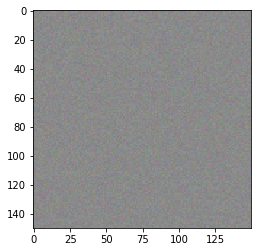

In [14]:
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

plt.imshow(input_img_data[0] / 255.);

And loop over it a few hundred times, *adding* the gradients (dampened by `step`, our "learning rate") as we go along

In [15]:
step = 0.1
losses = []
for i in range(1000):
    loss_value, grads_value = iterate([input_img_data])
    losses.append(loss_value)
    
    input_img_data += grads_value * step

After many iterations, we can see the general pattern that this layer is looking for (clipping values outside of `[0.0, 1.0]`)

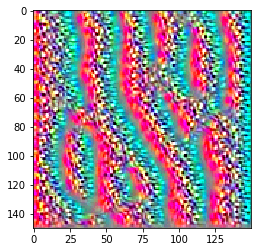

In [16]:
plt.imshow(np.clip(input_img_data[0] / 255., 0., 1.));

## Visualizing Many Filters of Many Layers

Packaging the above code into a helper function called `generate_pattern`, we can easily plot out a filter in a specific layer

In [17]:
import helpers

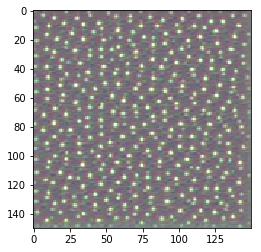

In [18]:
plt.imshow(helpers.generate_pattern(model, 'block3_conv1', filter_index=0));

Then borrowing once more from Chollet, we can do some clever loop magic™ and peek at several filters in each layer

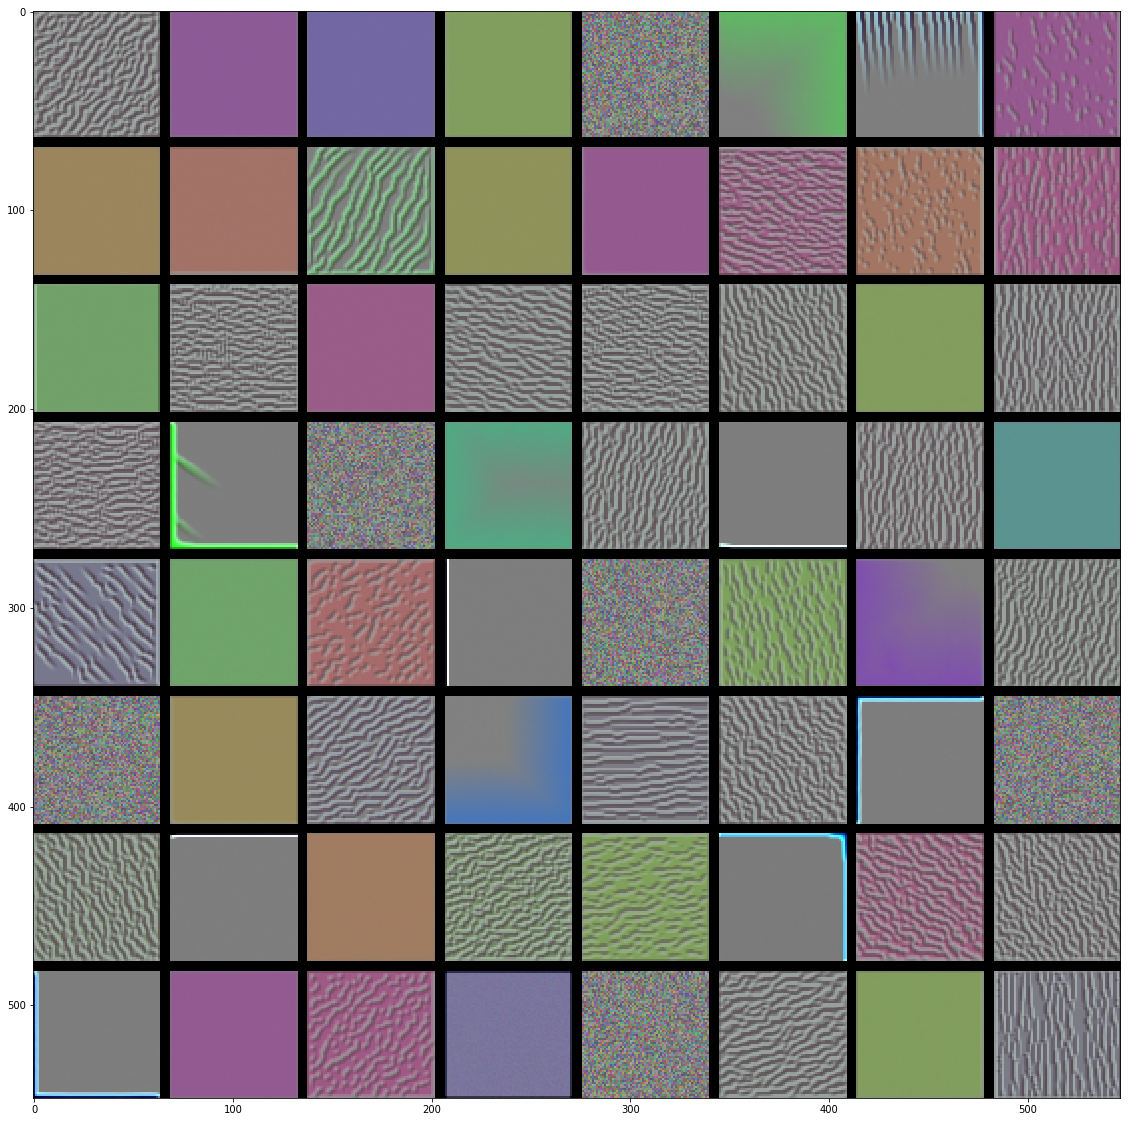

In [19]:
helpers.generate_layer(model, 'block1_conv1')

Look at how much more intricate the activations are in the later blocks of the Network

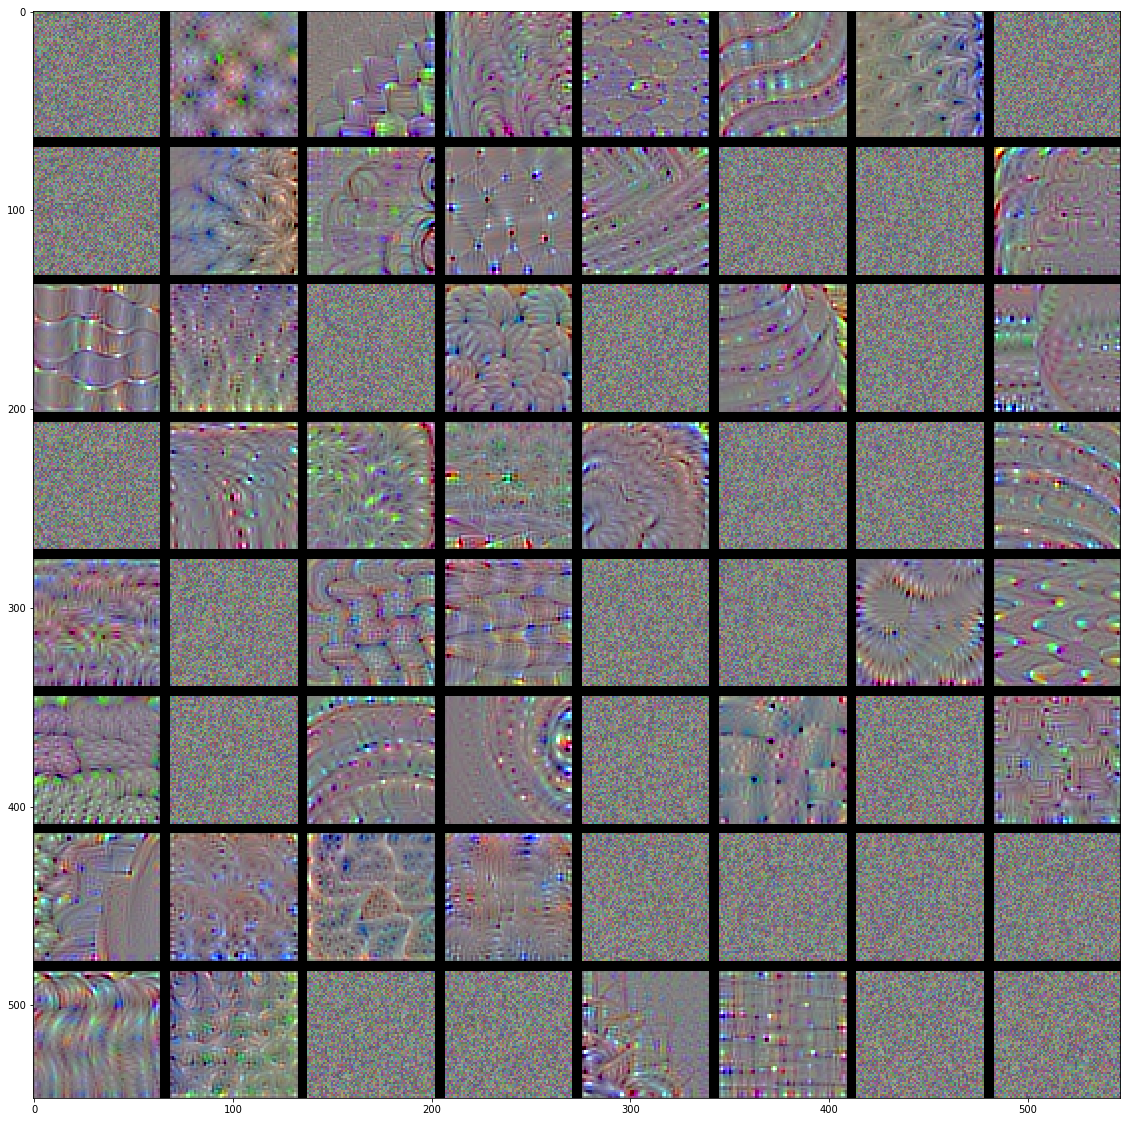

In [20]:
helpers.generate_layer(model, 'block4_conv3')

This is immediately consistent with out recurring notion of "increasing feature complexity, the deeper in the Network we go"